In [75]:
load('../../geneticScreening/CROP/variables_fromPreprocessing.image')

Z <- Z.stimulated

colnames(Z) <- gsub('_','-',colnames(Z))

design_matrix <- X_design.stimulated

cells <- rownames(design_matrix)[which(design_matrix$NFKB1==1)]

Y <- Y.stimulated[cells,]

colnames(Y) <- gsub('_','-',colnames(Y))

Y%>%dim

save(Z,Y,file = 'data.image')

In [1]:
load('data.image')

In [2]:
# Z represents control group: Cells by Genes
# Z represents perturbation group: Cells by Genes
# design_matrix: Cells by sgRNAs

In [3]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



# step1: data preprocessing

In [4]:
# select variable genes
library(Seurat)
## using Seurat to do preprocessing
suppressWarnings({
    
    Z.seurat <- CreateSeuratObject(counts = t(Z), min.cells = 0, min.features = 0)
    Z.seurat <- NormalizeData(Z.seurat)
    Z.seurat <- FindVariableFeatures(Z.seurat, selection.method = "vst", nfeatures = 600) 

    genes.variable <- VariableFeatures(Z.seurat)
})

Warning message:
“package ‘Seurat’ was built under R version 4.1.2”
Attaching SeuratObject



In [5]:
## norm
Z.norm <- (Z/rowSums(Z)*10000)
Y.norm <- (Y/rowSums(Y)*10000)

## log
Z.norm.log <- log(Z.norm+1)
Y.norm.log <- log(Y.norm+1)

In [6]:
## subset Z.norm.log with variable genes
Z.norm.log.sub <- Z.norm.log[,genes.variable]
Y.norm.log.sub <- Y.norm.log[,genes.variable]

## PCA
Z.pca.results <- prcomp(Z.norm.log.sub, center=TRUE, scale. = FALSE)


# step2: PC select

In [7]:
## select using threshold
th.sdev <- 1
th.multimodal <- 0.0125

pc.select.sdev <- which(Z.pca.results$sdev > th.sdev)
library(diptest)
select.pcs <- which((Z.pca.results$x)[,pc.select.sdev]%>%
                    apply(2,function(x){x%>%dip.test%>%.[['statistic']]})> th.multimodal)%>%names

In [8]:
## select using ranks
top.sdev <- 20
top.multimodal <- 3
#pc.select.sdev <- which(Z_pca_results$sdev > th.sdev)
library(diptest)
select.pcs <- ((Z.pca.results$x)[,1:top.sdev]%>%apply(2,function(x){x%>%dip.test%>%.[['statistic']]})%>%
               sort(decreasing = TRUE))[1:top.multimodal]%>%names


In [9]:
select.pcs

[1] "PC17" "PC8"  "PC1"

# step3: deconvolution

In [10]:
## projection
Z.PCA <- Z.pca.results$x
Z.projection.genebypc <- Z.pca.results$rotation

## map Y to PC space
Y.PCA <- Y.norm.log.sub  %*% Z.projection.genebypc

In [12]:
library(mixtools)

mixtools package, version 1.2.0, Released 2020-02-05
This package is based upon work supported by the National Science Foundation under Grant No. SES-0518772.




In [13]:
## control group cluster proporties estimation
set.seed(0)
Z.EM <- mvnormalmixEM(Z.PCA[,select.pcs],k = 2)

number of iterations= 174 


In [14]:
z.labels <- Z.EM$posterior%>%apply(1,which.max)

In [15]:
# plots of control cells

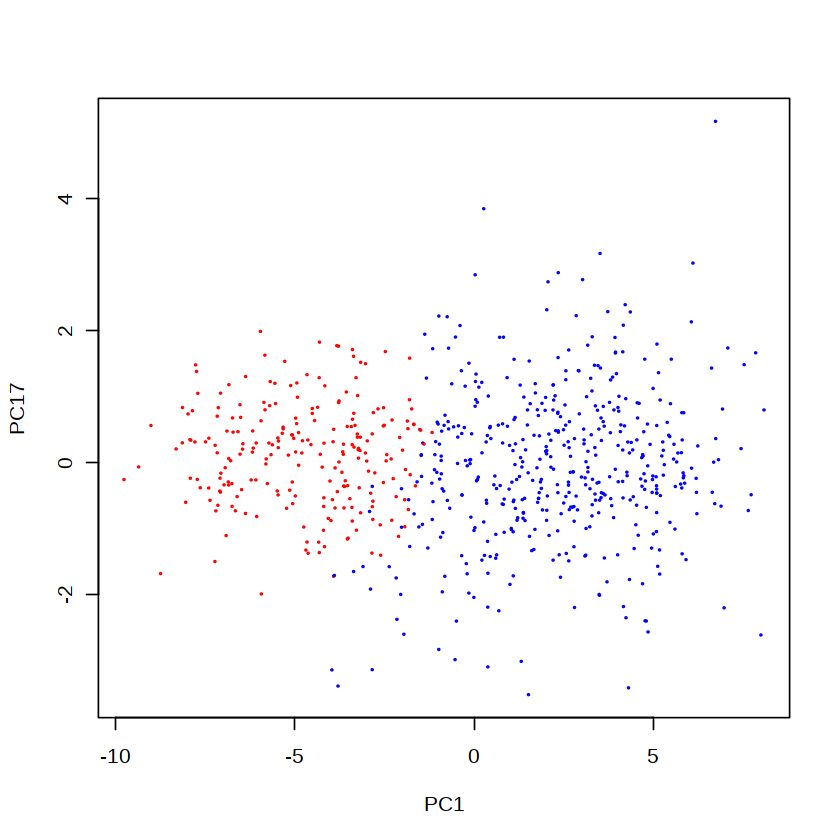

In [17]:
plot(Z.pca.results$x[,c(1,17)],cex=0.1,col = c('red','blue','green','black')[z.labels])

In [18]:
# deconvolution

In [19]:
beta.PC <- colMeans(Y.PCA) - colMeans(Z.PCA)

In [20]:
source('../function.r')

In [21]:
Y.EM <- get_beta_EM_sep_method(y = Y.PCA[,select.pcs],number.component = 2,
                               em = Z.EM$mu, es = Z.EM$sigma, el = Z.EM$lambda, 
                               beta_init = beta.PC[select.pcs] )
beta.scDecouple <- Y.EM$beta

cat("\ncurrent ratio: ",Y.EM$el)
cat("\noriginal ratio: ", Z.EM$lambda)



current ratio:  0.2289761 0.7710239
original ratio:  0.3332632 0.6667368

In [22]:
# show results
## ratio.changes
ratio.changes <- Y.EM$el - Z.EM$lambda 

In [23]:
ratio.changes

[1] -0.1042871  0.1042871

In [24]:
## cellular responses on PCs
beta.PC.scDecouple <- beta.PC
beta.PC.scDecouple[select.pcs] <- beta.scDecouple

# step3: downstream analysis

In [25]:
## cellular response of each genes


beta.variable.scDecouple <- beta.PC.scDecouple %*% t(Z.projection.genebypc) - colMeans(Z.norm.log.sub)

beta.gene.fc <- colMeans(Y.norm.log.sub) - colMeans(Z.norm.log.sub)

beta.gene.scDecouple <- beta.gene.fc
beta.gene.scDecouple[genes.variable] <- beta.variable.scDecouple[,genes.variable]

In [26]:
## gene ranking
results.genesort <- beta.gene.scDecouple[beta.gene.scDecouple%>%abs %>% sort(decreasing = TRUE)%>%names]

results.genesort.fc <- beta.gene.fc[beta.gene.fc%>%abs %>% sort(decreasing = TRUE)%>%names]

In [27]:
## gene enrichment

In [ ]:
library('enrichR')

degenes.num <- 1500

GO.enrich <- results.genesort[1:degenes.num]%>%names%>%enrichr('GO_Biological_Process_2018')%>%.$GO_Biological_Process_2018

Welcome to enrichR
Checking connection ... 

Enrichr ... 
Connection is Live!

FlyEnrichr ... 
Connection is available!

WormEnrichr ... 
Connection is available!

YeastEnrichr ... 
Connection is available!

FishEnrichr ... 
Connection is available!



In [ ]:
GO.enrich%>%head